<img src='../img/acam_logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='65%'></img>

<br>

# 1.3 AC SAF - GOME-2 - Level 2 - Absorbing Aerosol Height (AAH) data

###  Fire Monitoring - September 2015 - Indonesian Fires

The data of the GOME-2 `Absorbing Aerosol Height (AAH)` are provided by KNMI in the framework of the [EUMETSAT Satellite Application Facility on Atmospheric Composition Monitoring (AC SAF)](https://acsaf.org/index.html).

The Absorbing Aerosol Height (AAH) has been released in 2020. It uses the Absorbing Aerosol Index (AAI) product for aerosol detection, in order to derive the actual height of the absorbing aerosol layer.

The data can be retrieved from the [AC-SAF data access portal](https://acsaf.org/offline_access.php).

Find more information on the GOME-2 Level 2 AAH data product processed by KNMI in the [product user manual](https://acsaf.org/docs/pum/Product_User_Manual_AAH_Aug_2020.pdf).

#### Indonesian Fires 2015

In 2015, devastating wildfires in Indonesia broke out. As reported by [Reuters](https://www.reuters.com/article/us-indonesia-politics-haze-analysis-idUSKCN1UV0ZJ), "Between June and October that year, about 2.6 million hectares (6.4 million acres) of land burned in Indonesia, mainly on Sumatra and Borneo islands, said a 2016 World Bank report. A Harvard University study linked the 2015 haze to more than 100,000 premature deaths in Indonesia, Malaysia and Singapore."

#### Module outline:
* [1 - Load and browse AC-SAF GOME-2 Level 2 Absorbing Aerosol Height data](#load_browse_aah)
* [2 - Open a HDF5 group content as xarray.Dataset object](#open_aah)
* [3 - Build a xarray.DataArray object for a Metop-B GOME-2 Level 2 parameter](#build_xr_aah)
* [4 - Combine multiple HDF5 files in a xarray.DataArray object](#combine_aah)
* [5 - Filter AAH values based on Absorbing Aerosol Index (AAI) information](#filter_aah)
* [6 - Visualize filtered AAH values](#visualize_aah)



<hr>

#### Load required libraries

In [1]:
import os
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

from IPython.display import HTML
# Python libraries for visualisation
from matplotlib import pyplot as plt
from matplotlib import animation


import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='load_browse_aah'></a>Load and browse AC-SAF GOME-2 Level 2 Absorbing Aerosol Height data

The AC-SAF Metop-B GOME-2 Level 2 Absorbing Aerosol Height data is disseminated in the `HDF5` format. [xarray](http://xarray.pydata.org/en/stable/index.html) and [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) are two Python libraries you can use to access and manipulate datasets in `HDF5` format.

### <a id='disover_aah'></a>Discover the structure of AC-SAF Metop-B GOME-2 Level 2 product data files

The AAH data is in the folder `/eodata/gome2/aah/`. The data in the `HDF5` file is organized in groups. AC-SAF Metop-B GOME-2 Level 2 data contain four groups:

* `DATA`
 * Absorbing Aerosol Height information
* `GEOLOCATION`
 * Date & Time (all retrievals)
 * 4 Corner Coordinates & Centre of Ground Pixel
 * Solar, Line-of-Sight Zenith, and realtive Azimuth angles at TOA
 * Orbit information
* `METADATA`
 * General Metadata
* `PRODUCT_SPECIFIC_METADATA`
 * Product Metadata



<br>

You can load a `HDF5` file with the `Dataset` constructor of the [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) library. Load the file in `diskless non-persistent` mode by setting the `diskless` argument to `True` and the `persist` argument to `False`.

The resulting object is a `netCDF4.Dataset` object, which acts like a Python dictionary. Thus, with the `keys` function you can list the different groups the file contains.

In [3]:
file_name = '../eodata/gome2/aah/2015/09/09/S-O3M_GOME_ARS_02_M01_20150909005657Z_20150909015657Z_R_O_20201120210202Z.hdf5'

file = Dataset(file_name, diskless=True, persist=False)

groups = file.groups.keys()
groups


dict_keys(['DATA', 'GEOLOCATION', 'METADATA', 'PRODUCT_SPECIFIC_METADATA'])

Each group contains multiple variables. You can print out the variables of each group nicely formatted. This gives you a helpful overview of available parameters. You will mostly be interested in parameters of the `GEOLOCATION` and `DATA` groups.

The overview shows you, that one Metop-B GOME-2 Level 2 data file contains information on `AAH_AbsorbingAerosolHeight`.

In [4]:
for group in groups:
    print('{}:'.format(group))
    # variables in a group
    variables = sorted(file[group].variables.keys())
    # pretty print of variables in 3 columns
    for v1, v2, v3 in zip(variables[::3], variables[1::3], variables[2::3]):
        print('   - {:<30}- {:<30}- {:<}'.format(v1, v2, v3))
    if (len(variables) % 3) == 1:
        print('   - {:<30}'.format(variables[-1]))
    elif (len(variables) % 3) == 2:
        print('   - {:<30}- {:<}'.format(*variables[-2:]))
    # white line between one line and another
    print()

DATA:
   - AAH_AbsorbingAerosolHeight    - AAH_AbsorbingAerosolHeightError- AAH_AbsorbingAerosolPressure
   - AAH_AbsorbingAerosolPressureError- AAH_ErrorFlag                 - AAH_NElements
   - AAH_QualityInput              - AAH_QualityProcessing         - AAH_RegimeFlag
   - AAI                           - DegradationCorrectedResidue   - NElements
   - PMD_CloudFraction             - PMD_SceneHomogeneity          - PMD_SnowIceFrac
   - QualityInput                  - QualityProcessing             - SunGlintFlag
   - UncorrectedResidue            

GEOLOCATION:
   - IndexInScan                   - LatitudeCenter                - LatitudeCorner
   - LineOfSightAzimuthAngle       - LineOfSightZenithAngle        - LongitudeCenter
   - LongitudeCorner               - NElements                     - NrOfPixelsInScan
   - RelAzimuthAngle               - ScanDirection                 - ScannerAngle
   - ScatteringAngle               - SolarAzimuthAngle             - SolarZenithAngle
   - S

<br>

## <a id='open_aah'></a>Open a `HDF5` group content as `xarray.Dataset` object

In a next step, you can make use of the `xarray.backends.NetCDF4DataStore` feature of the [xarray](http://xarray.pydata.org/en/stable/index.html) library to open the `HDF5` group you are interested in as a xarray `Dataset` object. It is important to know that you can only get hold of one `HDF5` group item at the time.

As an example, you can load the `DATA` group and open it as xarray `Dataset`. You see that the data has two dimensions: `phony_dim_0` and `phony_dim_1` and 19 data variables.

In [5]:
data = file['DATA']
xr_data = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
xr_data

<xarray.Dataset>
Dimensions:                            (phony_dim_0: 32, phony_dim_1: 588)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables:
    AAH_AbsorbingAerosolHeight         (phony_dim_0, phony_dim_1) float32 ...
    AAH_AbsorbingAerosolHeightError    (phony_dim_0, phony_dim_1) float32 ...
    AAH_AbsorbingAerosolPressure       (phony_dim_0, phony_dim_1) float32 ...
    AAH_AbsorbingAerosolPressureError  (phony_dim_0, phony_dim_1) float32 ...
    AAH_ErrorFlag                      (phony_dim_0, phony_dim_1) int32 ...
    AAH_NElements                      (phony_dim_1) int32 ...
    AAH_QualityInput                   (phony_dim_0, phony_dim_1) int32 ...
    AAH_QualityProcessing              (phony_dim_0, phony_dim_1) int32 ...
    AAH_RegimeFlag                     (phony_dim_0, phony_dim_1) int32 ...
    AAI                                (phony_dim_0, phony_dim_1) float32 ...
    DegradationCorrectedResidue        (phony_dim_0, phony_dim_1) float32 ...
    NElements                          (phony_dim_1) int32 ...
    PMD_CloudFraction                  (phony_dim_0, phony_dim_1) float32 ...
    PMD_SceneHomogeneity               (phony_dim_0, phony_dim_1) float32 ...
    PMD_SnowIceFrac                    (phony_dim_0, phony_dim_1) float32 ...
    QualityInput                       (phony_dim_0, phony_dim_1) int32 ...
    QualityProcessing                  (phony_dim_0, phony_dim_1) int32 ...
    SunGlintFlag                       (phony_dim_0, phony_dim_1) int32 ...
    UncorrectedResidue                 (phony_dim_0, phony_dim_1) float32 ...

<br>

### <a id='select_aah'></a>Select and retrieve one specific parameter from a `xarray.Dataset` object

Let's say, you are interested in the Absorbing Aerosol Height parameter. With `xarray`, you can retrieve the parameter using square brackets `[]` and the name of the parameter of interest. 

The resulting object is a `xarray.DataArray`, which has the shape of a one-dimensional vector.

The `xarray.DataArray` holds also data attributes, which help a better understanding of the parameter, e.g. you get information about minimum and maximum values of the parameter and the unit of the data values.

In [6]:
aah = xr_data['AAH_AbsorbingAerosolHeight']
aah

<xarray.DataArray 'AAH_AbsorbingAerosolHeight' (phony_dim_0: 32, phony_dim_1: 588)>
array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Attributes:
    Title:          Absorbing Aerosol Height�
    Unit:           km�
�U
    FillValue:      -999.0
    ValidRangeMin:  -0.3
    ValidRangeMax:  200.0

## <a id='build_xr_aah'></a>Build a `xarray.DataArray` object for a Metop-B GOME-2 Level 2 parameter

For easier handling and plotting of the parameters, you can combine geolocation information and data values in a xarray `DataArray` structure, which can be created with the xarray `DataArray` constructor. 

You can make use of the function `generate_xr_from_1D_vec` which takes the following kwargs:
* `file` - the data file you want to load the data information from
* `lat_path` - internal paths to the latitude information of the HDF5 file
* `lon_path` - internal paths to the longitude information of the HDF5 file
* `variable` - xarray.DataArray with the variable information
* `parameter_name` - Name of the variable
* `longname` - Long name information of the variable
* `no_of_dims` - Number of dimensions of the data file
* `unit` - unit of the variable

We take the centre of the ground pixel as coordinates of the `DataArray`. The values can be retrieved from the internal paths `GEOLOCATION/LatitudeCentre` and `GEOLOCATION/LongitudeCentre` respectively.

The resulting object is a xarray `DataArray` object with latitude and longitude information and the AAH values as data values. The `DataArray` object contains 32 x 588 data pixels.

In [7]:
aah_xr = generate_xr_from_1D_vec(file = file, 
                                 lat_path = 'GEOLOCATION/LatitudeCenter', 
                                 lon_path = 'GEOLOCATION/LongitudeCenter', 
                                 variable = aah, 
                                 parameter_name = aah.name, 
                                 longname = aah.Title,
                                 no_of_dims = 2, 
                                 unit = aah.Unit)

aah_xr

<xarray.DataArray 'AAH_AbsorbingAerosolHeight' (x: 32, y: 588)>
array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)
Coordinates:
    latitude   (x, y) float32 56.47502 56.80021 57.120533 ... -999.0 -999.0
    longitude  (x, y) float32 -75.8195 -76.10679 -76.413185 ... -999.0 -999.0
Dimensions without coordinates: x, y
Attributes:
    long_name:  Absorbing Aerosol Height�
    units:      km�
�U

<br>

You can now continue to visualize the `DataArray` object. You can use the function `visualize_scatter()` to do it. The function combines matplotlib's `scatter` functionality with [Cartopy], a powerful library offering different projections for geographical data.

The `visualize_scatter` function takes the following kwargs:
* `xr_dataarray` - xarray.DataArray object
* `conversion_factor` - a number that can be used to convert data values
* `projection` - choose a cartopy projection
* `vmin` - Minimum value in the data range
* `vmax` - Maximum value in the data range
* `point_size` - size of the scatters
* `color_scale` - string of matplotlib's color ramp references
* `unit` - Unit of the data
* `title` - Title of the plot

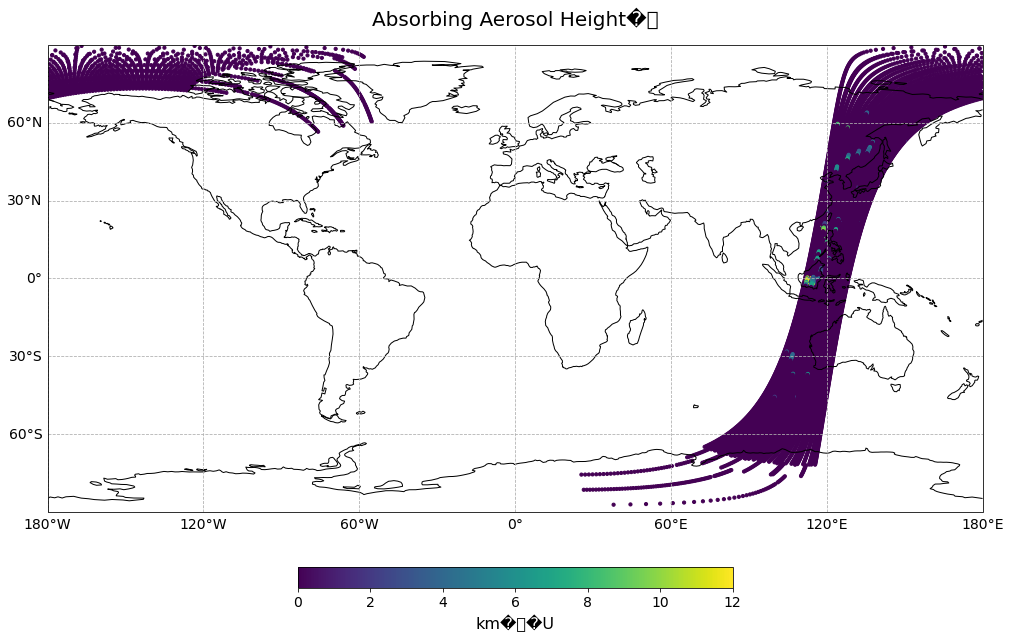

In [8]:
visualize_scatter(xr_dataarray=aah_xr, 
             conversion_factor=1, 
             projection=ccrs.PlateCarree(),
             vmin=0,
             vmax=12,
             point_size=10,
             color_scale='viridis',
             unit=aah_xr.units, 
             title=aah_xr.long_name)

<br>

## <a id='combine_aah'></a>Combine multiple HDF5 files in a `xarray.DataArray` object

AC-SAF Metop-B GOME-2 Level 2 data files for one individual day are stored in multiple files. In order to combine all sensed ground tracks for one individual day, you can apply the function `load_l2_data_xr`, which loads multiple `HDF5` files and returns a `xarray.DataArray` object with all ground pixels of all files. The function makes internally use of the function `generate_xr_from_1D_vec`.

Let us load all the AC-SAF Metop-B GOME-2 Level 2 data files for 9 September 2015. The function takes the following kwargs:
* `directory` - file directory containing the `HDF5` files
* `internal_filepath` - internal filepath containing the data information, e.g. `DATA`
* `parameter` - name of the parameter
* `lat_path` - path to the latitude information in the `HDF5` file
* `lon_path` - path to the longitude information in the `HDF5` file
* `no_of_dims` - Number of dimensions of the file
* `paramname` - Name of variable
* `unit` - Unit of the variable
* `longname` - Long name of the variable

In [9]:
directory='../eodata/gome2/aah/2015/09/09'
aah_da_mf = load_l2_data_xr(directory= directory,
                           internal_filepath='DATA',
                           parameter='AAH_AbsorbingAerosolHeight',
                           lat_path='GEOLOCATION/LatitudeCenter',
                           lon_path='GEOLOCATION/LongitudeCenter',
                           no_of_dims=2,
                           paramname=aah.name,
                           unit=aah.Unit,
                           longname=aah.Title)

aah_da_mf

<xarray.DataArray 'AAH_AbsorbingAerosolHeight' (ground_pixel: 507904)>
array([-999., -999., -999., ..., -999., -999., -999.], dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 56.592785 66.35436 ... -999.0 -999.0
    longitude     (ground_pixel) float32 5.331203 -7.822516 ... -999.0 -999.0
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 0 ... 31 31 31 31 31 31 31
  - y             (ground_pixel) int64 0 1 2 3 4 5 6 ... 582 583 584 585 586 587
Attributes:
    long_name:  Absorbing Aerosol Height�
    units:      km�
�U

<br>

If you visualize the data array containing ground pixel information from multiple files, you see that for one day, almost all part on Earth are covered by Metop-B GOME-2. You can again use the function `visualize_scatter` to visualize the data as a scatter plot.

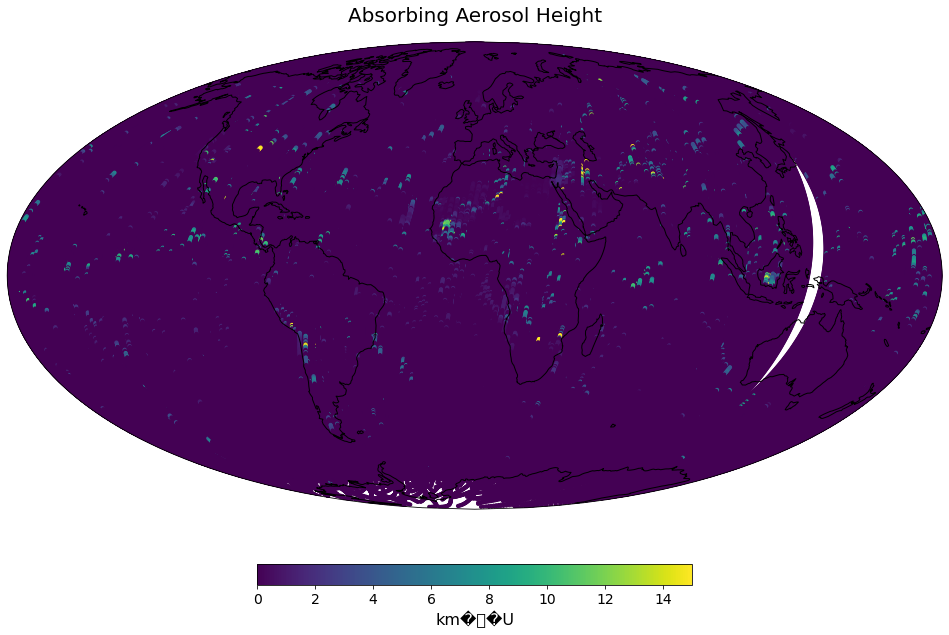

In [10]:
visualize_scatter(xr_dataarray=aah_da_mf, 
             conversion_factor=1,
             projection=ccrs.Mollweide(), 
             vmin=0, 
             vmax=aah_da_mf.max(), 
             point_size=10, 
             color_scale='viridis', 
             unit=aah_da_mf.units, 
             title=str(aah_da_mf.long_name)[0:24])

<br>

## <a id='filter_aah'></a>Filter AAH values based on Absorbing Aerosol Index (AAI) information

Absorbing Aerosol Height information is strongly linked with Absorbing Aerosol Index values. AAI values below 2 index points correspond to scenes with too low amounts of aerosol to result in a reliable Absorbing Aerosol Height (AAH). These situations have already been flagged in the data file. However, even AAI values larger than 2 index points but smaller than 4 index points are often not thick enough for a reliable AAH retrieval. For this reason, we need to flag only the AAH values where the AAI values are larger than 4.

As a first step, you have to load the `AAI` values, which are part of the data files and can be found as well in the `DATA` group. You can use the function `load_l2_data_xr` to load the AAI values for all files for the same day.

In [11]:
aai = load_l2_data_xr(directory=directory,
                                    internal_filepath='DATA', 
                                    parameter='AAI', 
                                    lat_path='GEOLOCATION/LatitudeCenter', 
                                    lon_path='GEOLOCATION/LongitudeCenter', 
                                    no_of_dims=2, 
                                    paramname='AAI', 
                                    unit='-', 
                                    longname='Absorbing Aerosol Index')
aai

<xarray.DataArray 'AAI' (ground_pixel: 507904)>
array([-999., -999., -999., ..., -999., -999., -999.], dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 56.592785 66.35436 ... -999.0 -999.0
    longitude     (ground_pixel) float32 5.331203 -7.822516 ... -999.0 -999.0
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 0 ... 31 31 31 31 31 31 31
  - y             (ground_pixel) int64 0 1 2 3 4 5 6 ... 582 583 584 585 586 587
Attributes:
    long_name:  Absorbing Aerosol Index
    units:      -

<br>

In a next step, you can mask the AAH data array with the help of the previously loaded data array that contains the AAI values. You can use the function `generate_masked_array`. You want to filter out all AAH values, where AAI is less than 4 index points. As a result, only 592 AAH values remain valid.

In [12]:
aah_da_masked = generate_masked_array(aah_da_mf, aai, 4, '>', drop=True)
aah_da_masked

<xarray.DataArray (ground_pixel: 592)>
array([-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
        5.39504290e-01,  5.64081013e-01, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02,  6.95908356e+00, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02,  7.24839151e-01,  7.20523000e-01,  7.35235274e-01,
        3.32004571e+00,  3.18365312e+00,  8.16737771e-01,  8.46338391e-01,
        9.65938866e-01,  4.32276487e+00, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02,  7.80908823e-01,  8.91651213e-01,  1.05305014e+01,
        5.72264862e+00,  1.88314915e-01,  8.87894535e+00,  7.84879446e-01,
        6.93301916e+00,  4.28449154e+00,  1.60839307e+00,  1.61812031e+00,
        1.01651716e+00,  4.77982163e-02,  9.14393044e+00,  2.71514630e+00,
        1.82519090e+00,  7.92474079e+00,  8.59282875e+00,  1.88596869e+00,
        3.54353786e+00,  2.21018267e+00,  1.56462193e+00,  1.52118933e+00,
        1.23266482e+00,  2.46981382e+00,  3.67410946e+00,  6.63365841e+00,
        6.42616081e+00,  1.39033914e+00,  1.61190724e+00,  2.07801366e+00,
        1.84126532e+00,  3.94236779e+00,  6.84212065e+00,  4.07416821e+00,
        1.20832014e+00,  9.69380081e-01,  1.84974754e+00,  7.45544493e-01,
        1.67632151e+00,  2.63241124e+00,  7.21764326e+00,  4.88526440e+00,
...
        1.10388482e+00,  7.86683261e-01,  3.71286362e-01,  2.15274215e-01,
        3.32929850e-01,  5.31422853e-01,  8.01089168e-01,  8.23473454e-01,
        9.24555302e-01,  7.60308743e-01,  5.57352722e-01,  2.39218935e-01,
        2.19368786e-01,  1.11360006e-01,  1.62704140e-01,  2.27964327e-01,
        4.15320098e-01,  1.73536509e-01,  2.96605021e-01,  1.97499499e-01,
        1.35072812e-01,  1.43794969e-01,  2.45278686e-01,  2.61021078e-01,
        1.97150037e-01,  3.77585411e-01,  4.99394983e-01,  4.85885590e-01,
        4.75867778e-01,  8.75292897e-01,  8.23589623e-01,  8.15145850e-01,
        6.91881478e-01,  6.55582726e-01,  1.24617808e-01,  1.50440007e-01,
        6.05520964e-01,  7.57359862e-01,  9.97238219e-01,  1.17967761e+00,
        1.36922288e+00,  1.20046258e+00, -9.99000000e+02,  1.23484802e+00,
        1.27234709e+00,  9.67165053e-01,  5.25769567e+00,  1.70290709e+00,
        1.76883447e+00,  1.92601335e+00,  1.81884789e+00,  9.08075690e-01,
        4.32363129e+00,  4.71020937e+00,  1.48437560e+00, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
        7.78965044e+00, -9.99000000e+02, -9.99000000e+02,  1.75480068e+00,
        2.77061939e+00,  2.81509948e+00,  4.43458939e+00,  5.45265388e+00,
        4.78292084e+00,  5.38653374e+00,  6.61335611e+00,  6.91792393e+00,
        3.92910576e+00, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02],
      dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 9.458876 3.977994 ... 20.242476
    longitude     (ground_pixel) float32 -151.78885 -153.80547 ... 131.05954
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 5 6 29 5 6 6 6 6 ... 25 25 25 28 29 30 30
  - y             (ground_pixel) int64 276 292 284 287 284 ... 193 279 273 274
Attributes:
    long_name:  Absorbing Aerosol Height�
    units:      km�
�U

<br>

## <a id='visualize_aah'></a> Visualize filtered AAH values

In a last step, you can visualize again the data array with the filtered AAH information. 

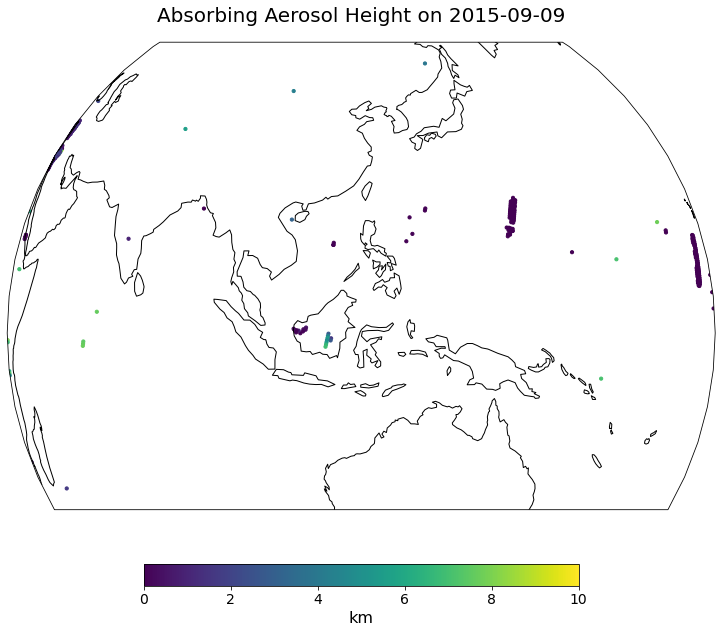

In [13]:
visualize_scatter(xr_dataarray=aah_da_masked, 
             conversion_factor=1,
             projection=ccrs.Orthographic(120), 
             vmin=0, 
             vmax=10, 
             point_size=10, 
             color_scale='viridis', 
             unit=aah_da_masked.units[0:2], 
             title=str(aah_da_masked.long_name)[0:24] + ' on 2015-09-09'
                 )

<br>

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="../LICENSE">MIT License</a> and is developed under a Copernicus contract.